In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from scipy import stats
from scipy.sparse import issparse
from abc import ABCMeta, abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin
#from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_X_y, check_array, _get_n_jobs, gen_even_slices
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.extmath import weighted_mode
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils import check_array
from sklearn.externals import six
 
from __future__ import division
import threading
from scipy.sparse import hstack as sparse_hstack
from sklearn.externals.joblib import Parallel, delayed
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._tree import DTYPE, DOUBLE
from sklearn.ensemble.base import BaseEnsemble, _partition_estimators
from sklearn.utils.fixes import parallel_helper

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import pairwise
from sklearn.exceptions import DataConversionWarning, NotFittedError
from sklearn.utils.extmath import weighted_mode

from sklearn.neighbors.base import NeighborsBase
from sklearn.neighbors.ball_tree import BallTree
from sklearn.neighbors.kd_tree import KDTree
    
    
plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

c:\python27\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
business_data = pd.read_csv('business.csv', dtype=unicode)
review_data = pd.read_csv('review.csv')
user_data = pd.read_csv('user.csv')

In [4]:
review_user_data = review_data.merge(user_data,
                                     left_on='user_id',
                                     right_on='user_id',
                                     how='outer',
                                     suffixes=('_review', '_user'))

In [5]:
business_review_user_data = review_user_data.merge(business_data,
                                                   left_on='business_id',
                                                   right_on='business_id',
                                                   how='outer',
                                                   suffixes=('_reviewuser', '_business'))

In [6]:
business_review_user_data = business_review_user_data.rename(columns = {'name_reviewuser':'name_user',
                                                                        'review_count_reviewuser':'review_count_user',
                                                                        'stars_reviewuser':'stars_review'})

In [7]:
cols = business_review_user_data.columns
cols = cols.map(lambda x: x.replace(' ', '_').lower() if isinstance(x, (str, unicode)) else x)
business_review_user_data.columns = cols
firstFewRows = business_review_user_data.ix[:,['categories','text','stars_review','business_id']]
firstFewRowsList = firstFewRows['categories'].tolist()
restaurantsDF = firstFewRows[firstFewRows['categories'].str.contains('Restaurants')]

c:\python27\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Text(0,0.5,u'Number of reviews')

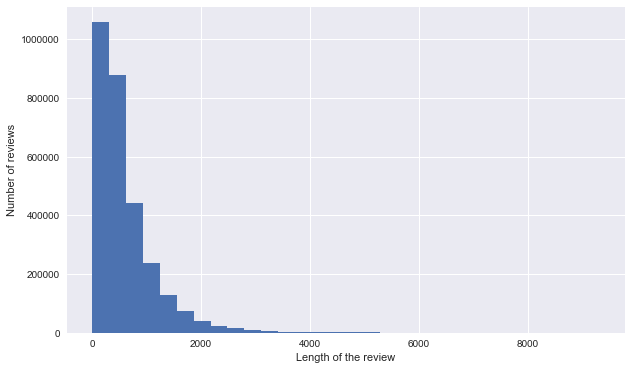

In [8]:
restaurantsDF.text.dropna().str.len().hist(bins=30)
xlabel('Length of the review')
ylabel('Number of reviews')

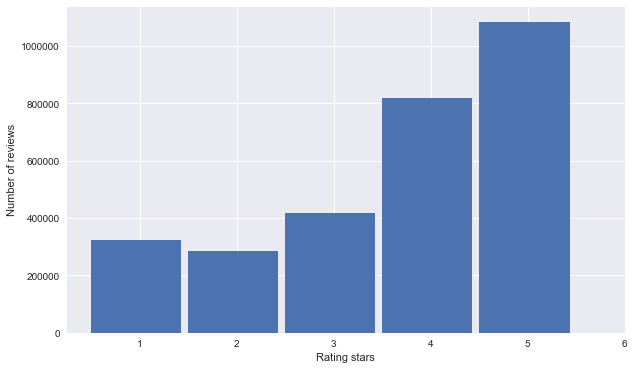

In [9]:
bins = [1 ,2 ,3 ,4, 5, 6]
restaurantsDF.stars_review.hist(bins=bins, align='left', width=0.93)
xticks(bins)
xlabel('Rating stars')
ylabel('Number of reviews')
plt.show()

In [10]:
def central_tendency_plot(point, ci, y, color, label):
    plt.plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plt.plot(point, y, "o", color=color, markersize=10)

In [11]:
def plot_error_dist(column, name):
    d = column.tolist()
    d = [0 if np.math.isnan(x) else x for x in d]
    m = np.mean(d)
    med = np.median(d)
    s = np.std(d)

    x = np.linspace(min(d), max(d), 1000)
    gauss = lambda x, m, s: (1 / (s * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - m) / s) ** 2))
    y = gauss(x, m, s)

    bins = np.arange(min(d), max(d)+1, 1)
    n, b, patches = plt.hist(d, bins=bins+1, normed=True, align='left', width=0.95)
    pylab.xticks(bins)
    bin_max = np.max(n)
    m_y = bin_max/5
    
    central_tendency_plot(m, [m - s, m + s], m_y, colors[1], "std dev")

    ci = np.percentile(d, [16, 84])
    central_tendency_plot(med, ci,  m_y - bin_max/10, colors[2], "68% CI")
    
    plt.legend(loc=0)
    plt.plot(x, y, color=colors[4])
    plt.xlabel('Error')
    plt.ylabel('Normalized Frequency')
    title = name + ' Error Distribution'
    plt.title(title)
    plt.show()

In [12]:
restaurantsDF['predicted_rating'] = round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

print "Baseline Rating:", round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

Baseline Rating: 4.0


c:\python27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
t = restaurantsDF[['stars_review', 'predicted_rating']].dropna(how='any')

In [14]:
precision = metrics.precision_score(t.stars_review, t.predicted_rating, average='macro')
recall = metrics.recall_score(t.stars_review, t.predicted_rating, average='macro')
f1 = metrics.f1_score(t.stars_review, t.predicted_rating, average='macro')
accuracy = accuracy_score(t.stars_review, t.predicted_rating)

baselineResult = {}

data = {'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy}

baselineResult['Baseline'] = data
pd.DataFrame(baselineResult).T

c:\python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy,f1_score,precision,recall
Baseline,0.279661,0.087417,0.055932,0.2


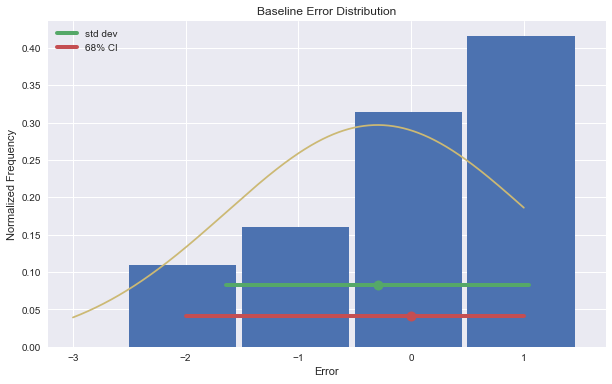

In [15]:
error = restaurantsDF.stars_review - restaurantsDF.predicted_rating
plot_error_dist(error, "Baseline")

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Heisenberg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stoplist = set(stopwords.words("english"))

In [18]:
numTopics = 15

In [19]:
t = restaurantsDF.dropna(how='all')

In [20]:
minReviewLen = 50
maxReviewLen = 100

print "Number of rows selected:",len(t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen])
restaurantsDF = t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen]

Number of rows selected:

c:\python27\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


 85617

c:\python27\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [21]:
def process_reviews(dirty_data_set):
    clean_data_set = []
    for review in dirty_data_set:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def generate_topic_dist_matrix(lda, numTopics, corpus, all_dist, star):
    topic_dist = [0] * numTopics
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    for doc in corpus:
        vec = dictionary.doc2bow(doc.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * numTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist

In [22]:
starsGroup = restaurantsDF.groupby('stars_review')

all_1stars_text = starsGroup.get_group(1.0)['text']
all_2stars_text = starsGroup.get_group(2.0)['text']
all_3stars_text = starsGroup.get_group(3.0)['text']
all_4stars_text = starsGroup.get_group(4.0)['text']
all_5stars_text = starsGroup.get_group(5.0)['text']

all_1stars_labels = [1.0]*len(all_1stars_text)
all_2stars_labels = [2.0]*len(all_2stars_text)
all_3stars_labels = [3.0]*len(all_3stars_text)
all_4stars_labels = [4.0]*len(all_4stars_text)
all_5stars_labels = [5.0]*len(all_5stars_text)

In [23]:
from sklearn.cross_validation import train_test_split

all_1stars_text_train, all_1stars_text_test, all_1stars_labels_train, all_1stars_labels_test = train_test_split(all_1stars_text, all_1stars_labels, test_size=0.20)
all_2stars_text_train, all_2stars_text_test, all_2stars_labels_train, all_2stars_labels_test = train_test_split(all_2stars_text, all_2stars_labels, test_size=0.20)
all_3stars_text_train, all_3stars_text_test, all_3stars_labels_train, all_3stars_labels_test = train_test_split(all_3stars_text, all_3stars_labels, test_size=0.20)
all_4stars_text_train, all_4stars_text_test, all_4stars_labels_train, all_4stars_labels_test = train_test_split(all_4stars_text, all_4stars_labels, test_size=0.20)
all_5stars_text_train, all_5stars_text_test, all_5stars_labels_train, all_5stars_labels_test = train_test_split(all_5stars_text, all_5stars_labels, test_size=0.20)

c:\python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# Process the reviews
corpus_5stars = process_reviews(all_5stars_text_train)
corpus_4stars = process_reviews(all_4stars_text_train)
corpus_3stars = process_reviews(all_3stars_text_train)
corpus_2stars = process_reviews(all_2stars_text_train)
corpus_1stars = process_reviews(all_1stars_text_train)

print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)

Number of 5-star reviews after processing:  34712
Number of 4-star reviews after processing:  18714
Number of 3-star reviews after processing:  6398
Number of 2-star reviews after processing:  3584
Number of 1-star reviews after processing:  5084


In [25]:
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

In [26]:
def perform_lda(allReviewsTrain, numTopics):
    corpus = []
    for review in allReviewsTrain:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            corpus.append(texts)
        except:
            pass

    # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_2 = [dictionary.doc2bow(text) for text in corpus]
    #corpora.MmCorpus.serialize('LDA/restaurant_reviews.mm', corpus_2)
    
    lda = models.LdaModel(corpus_2, num_topics=numTopics, id2word=dictionary)
    return lda

In [27]:
%time lda = perform_lda(all_text_train, numTopics)

Wall time: 2min 44s


In [28]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []

topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in xrange(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_train_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

In [29]:
# Process the test reviews
corpus_5stars = process_reviews(all_5stars_text_test)
corpus_4stars = process_reviews(all_4stars_text_test)
corpus_3stars = process_reviews(all_3stars_text_test)
corpus_2stars = process_reviews(all_2stars_text_test)
corpus_1stars = process_reviews(all_1stars_text_test)


In [30]:
all_5_4_test = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars)

In [31]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in xrange(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_test_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

In [32]:
topic_dist_test_1_2_3_4_5_df.shape

(17125, 16)

In [33]:
topic_dist_train_1_2_3_4_5_df.shape

(68492, 16)

In [34]:
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1

In [35]:
topic_dist_train_1_2_3_4_5_df['Sentiment'] = topic_dist_train_1_2_3_4_5_df['Star'].map(getSentiment)
topic_dist_test_1_2_3_4_5_df['Sentiment'] = topic_dist_test_1_2_3_4_5_df['Star'].map(getSentiment)

In [36]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
print features

['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15']


In [37]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star']

LDAResults = {}

In [38]:
class KNN(NeighborsBase):
   
    def __init__(self, n_neighbors=5,
                 weights='uniform', algorithm='auto', leaf_size=30,
                 p=2, metric='minkowski', metric_params=None, n_jobs=1,
                 **kwargs):

        self._init_params(n_neighbors=n_neighbors,
                          algorithm=algorithm,
                          leaf_size=leaf_size, metric=metric, p=p,
                          metric_params=metric_params, n_jobs=n_jobs, **kwargs)

    def get_neighbors(self, X=None, n_neighbors=None, return_distance=True):
        
        n_neighbors = self.n_neighbors       
        query_is_train = False
        X = check_array(X, accept_sparse='csr')
        train_size = self._fit_X.shape[0]
        n_samples, _ = X.shape
        sample_range = np.arange(n_samples)[:, None]
        n_jobs = _get_n_jobs(self.n_jobs)
        
        result = Parallel(n_jobs, backend='threading')(
            delayed(self._tree.query, check_pickle=False)(
                X[s], n_neighbors, return_distance)
            for s in gen_even_slices(X.shape[0], n_jobs)
        )
        if return_distance:
            dist, neigh_ind = tuple(zip(*result))
            result = np.vstack(dist), np.vstack(neigh_ind)
        else:
            result = np.vstack(result)
        return result


    def get_predictions(self, X):

            X = check_array(X, accept_sparse='csr')

            neigh_dist, neigh_ind = self.get_neighbors(X)

            classes_ = self.classes_
            _y = self._y
            if not self.outputs_2d_:
                _y = self._y.reshape((-1, 1))
                classes_ = [self.classes_]

            n_outputs = len(classes_)
            n_samples = X.shape[0]

            y_pred = np.empty((n_samples, n_outputs), dtype=classes_[0].dtype)
            for k, classes_k in enumerate(classes_):
                mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
                mode = np.asarray(mode.ravel(), dtype=np.intp)
                y_pred[:, k] = classes_k.take(mode)

            if not self.outputs_2d_:
                y_pred = y_pred.ravel()

            return y_pred

    def get_model(self, X, y):
        if not isinstance(X, (KDTree, BallTree)):
            X, y = check_X_y(X, y, "csr", multi_output=True)

        if y.ndim == 1 or y.ndim == 2 and y.shape[1] == 1:
            if y.ndim != 1:
                warnings.warn("A column-vector y was passed when a 1d array "
                              "was expected. Please change the shape of y to "
                              "(n_samples, ), for example using ravel().",
                              DataConversionWarning, stacklevel=2)

            self.outputs_2d_ = False
            y = y.reshape((-1, 1))
        else:
            self.outputs_2d_ = True

        check_classification_targets(y)
        self.classes_ = []
        self._y = np.empty(y.shape, dtype=np.int)
        for k in range(self._y.shape[1]):
            classes, self._y[:, k] = np.unique(y[:, k], return_inverse=True)
            self.classes_.append(classes)

        if not self.outputs_2d_:
            self.classes_ = self.classes_[0]
            self._y = self._y.ravel()

        return self._fit(X)

In [39]:
"""Multinomial Naive Bayes Classification"""

class MultinomialNB():

    def predict(self, X):
        acc_cond_log= self.conditional(X)
        return self.classes[np.argmax(acc_cond_log, axis=1)]
    
    
    def fit(self, X, y):
        self.alpha = 1.0
        self.fit_prior = True
        self.class_prior = None

        X, y = check_X_y(X, y, 'csr')

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        Y = Y.astype(np.float64)
        class_prior = self.class_prior
        
        self.num_classes = np.zeros(Y.shape[1], dtype=np.float64) + Y.sum(axis=0);
        self.num_features = np.zeros((Y.shape[1], X.shape[1]),
                                       dtype=np.float64) + safe_sparse_dot(Y.T, X);
        
        self.feature_log_prob = (np.log(self.num_features + self.alpha) -
                                  np.log((self.num_features + self.alpha).sum(axis=1).reshape(-1, 1)))
        self.modify_class_prior(class_prior=class_prior)
        return self
        

    def conditional(self, X):
        check_is_fitted(self, "classes")
        X = check_array(X, accept_sparse='csr')
        return (safe_sparse_dot(X, self.feature_log_prob.T) +
                self.class_log_prior)


    def modify_class_prior(self, class_prior=None):
        n_classes = len(self.classes)
        if class_prior is not None:
            self.class_log_prior = np.log(class_prior)
        elif self.fit_prior:
            self.class_log_prior = (np.log(self.num_classes) -
                                     np.log(self.num_classes.sum()))
        else:
            self.class_log_prior = np.zeros(n_classes) - np.log(n_classes)
            
    def get_model(self,X,Y):
        return self.fit(X,Y)
    
    def get_predictions(self,X):
        return self.predict(X)

In [40]:
"""Random Forest Classification"""

def generate_indices(n_samples):
    random_instance = np.random.mtrand._rand
    indices = random_instance.randint(0, n_samples, n_samples)
    return indices

def build_trees(tree, X, y, sample_wt):
    n_samples = X.shape[0]
    if sample_wt is None:
        curr_sample_wt = np.ones((n_samples,), dtype=np.float64)
    else:
        curr_sample_wt = sample_wt.copy()

    indices = generate_indices(n_samples)
    curr_sample_wt *= np.bincount(indices, minlength=n_samples)

    tree.fit(X, y, sample_weight=curr_sample_wt, check_input=False)
    
    return tree

def accumulate_prediction(predict, X, out, lock):
        prediction = predict(X, check_input=False)
        with lock:
            if len(out) == 1:
                out[0] += prediction
            else:
                for i in range(len(out)):
                    out[i] += prediction[i]

In [41]:
class RandomForestModel(six.with_metaclass(ABCMeta, BaseEnsemble)):
    
    @abstractmethod
    def __init__(self,
                 base_estimator,
                 n_estimators=100,
                 estimator_params=tuple()):
        super(RandomForestModel, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            estimator_params=estimator_params)

    def get_model(self, X, y,sample_weight = None):
        # Validate or convert input data
        X = check_array(X, accept_sparse="csc", dtype=DTYPE)
        y = check_array(y, accept_sparse='csc', ensure_2d=False, dtype=None)
        if issparse(X):
            # Pre-sort indices to avoid that each individual tree of the
            # ensemble sorts the indices.
            X.sort_indices()

        # Remap output
        n_samples, self.n_features_ = X.shape
        y = np.atleast_1d(y)
        
        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))

        self.n_outputs_ = y.shape[1]
        y, expanded_class_weight = self.check_y_class_wt(y)

        if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
            y = np.ascontiguousarray(y, dtype=DOUBLE)

        if expanded_class_weight is not None:
            sample_weight = expanded_class_weight

        # Check parameters
        self._validate_estimator()

        random_state = np.random.mtrand._rand

        # Free allocated memory, if any
        self.estimators_ = []
        n_more_estimators = self.n_estimators - len(self.estimators_)

        trees = []
        for i in range(n_more_estimators):
            tree = self._make_estimator(append=False,
                                        random_state=random_state)
            trees.append(tree)

        trees = Parallel(n_jobs=2,
                         backend="threading")(
            delayed(build_trees)(t, X, y, sample_weight)
            for i, t in enumerate(trees))

        # Collect newly grown trees
        self.estimators_.extend(trees)

        # Decapsulate classes_ attributes
        if hasattr(self, "classes_") and self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]

        return self

    def check_y_class_wt(self, y):
        return y, None
    
    def check_X(self, X):
        return self.estimators_[0]._validate_X_predict(X, check_input=True)

In [42]:
class RFClassifier(six.with_metaclass(ABCMeta, RandomForestModel,
                                          ClassifierMixin)):

    def __init__(self,
                 base_estimator=DecisionTreeClassifier(),
                 n_estimators=100):

        super(RFClassifier, self).__init__(
            base_estimator,
            n_estimators=n_estimators,
            estimator_params=("criterion", "max_depth", "min_samples_split",
                              "min_samples_leaf", "min_weight_fraction_leaf",
                              "max_features", "max_leaf_nodes",
                              "min_impurity_decrease", "min_impurity_split"))

        self.criterion = "gini"
        self.max_depth = None
        self.min_samples_split = 2
        self.min_samples_leaf = 1
        self.min_weight_fraction_leaf = 0.
        self.max_features = "auto"
        self.max_leaf_nodes = None
        self.min_impurity_decrease = 0.
        self.min_impurity_split = None

    def check_y_class_wt(self, y):
        y = np.copy(y)

        self.classes_ = []
        self.n_classes_ = []

        y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
        for k in range(self.n_outputs_):
            classes_k, y_store_unique_indices[:, k] = np.unique(y[:, k], return_inverse=True)
            self.classes_.append(classes_k)
            self.n_classes_.append(classes_k.shape[0])
        y = y_store_unique_indices

        return y, None
    
    def get_predictions(self, X):
        proba = self.predict_proba(X)

        if self.n_outputs_ == 1:
            return self.classes_.take(np.argmax(proba, axis=1), axis=0)

        else:
            n_samples = proba[0].shape[0]
            predictions = np.zeros((n_samples, self.n_outputs_))

            for k in range(self.n_outputs_):
                predictions[:, k] = self.classes_[k].take(np.argmax(proba[k],
                                                                    axis=1),
                                                          axis=0)

            return predictions

    def predict_proba(self, X):
        # Check data
        X = self.check_X(X)

        # Assign chunk of trees to jobs
        n_jobs, _, _ = _partition_estimators(self.n_estimators, 2)

        # avoid storing the output of every estimator by summing them here
        all_proba = [np.zeros((X.shape[0], j), dtype=np.float64)
                     for j in np.atleast_1d(self.n_classes_)]
        lock = threading.Lock()
        Parallel(n_jobs=n_jobs, backend="threading")(
            delayed(accumulate_prediction)(e.predict_proba, X, all_proba, lock)
            for e in self.estimators_)

        for proba in all_proba:
            proba /= len(self.estimators_)

        if len(all_proba) == 1:
            return all_proba[0]
        else:
            return all_proba

In [43]:
clfs = [KNN(),MultinomialNB(),RFClassifier()]
clf_names = ['K-Nearest Neighbor','Multinomial Naive Bayes','Random Forest']

for (i, clf_) in enumerate(clfs):
    clf = clf_.get_model(x_train, y_train)
    preds = clf.get_predictions(x_test)
    
    precision = metrics.precision_score(y_test, preds, average = 'micro')
    recall = metrics.recall_score(y_test, preds, average = 'micro')
    f1 = metrics.f1_score(y_test, preds, average = 'micro')
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LDAResults[clf_names[i]] = data

c:\python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(LDAResults).T[cols].T

,K-Nearest Neighbor,Multinomial Naive Bayes,Random Forest
precision,0.411328,0.506745,0.463708
recall,0.411328,0.506745,0.463708
f1_score,0.411328,0.506745,0.463708
accuracy,0.411328,0.506745,0.463708


In [45]:
for model, val in LDAResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

-------------------------
MODEL: K-Nearest Neighbor
-------------------------
The precision for this classifier is 0.411328467153
The recall for this classifier is    0.411328467153
The f1 for this classifier is        0.411328467153
The accuracy for this classifier is  0.411328467153
Here is the classification report:
             precision    recall  f1-score   support

          1       0.16      0.14      0.15      1271
          2       0.11      0.05      0.07       897
          3       0.11      0.07      0.09      1600
          4       0.30      0.31      0.31      4679
          5       0.54      0.60      0.57      8678

avg / total       0.39      0.41      0.40     17125

--------------------
MODEL: Random Forest
--------------------
The precision for this classifier is 0.463708029197
The recall for this classifier is    0.463708029197
The f1 for this classifier is        0.463708029197
The accuracy for this classifier is  0.463708029197
Here is the classification report:

In [46]:
vectorizer = TfidfVectorizer()

tfidfXtrain = vectorizer.fit_transform(all_text_train)
tfidfXtest = vectorizer.transform(all_text_test)

tfidfYtrain = topic_dist_train_1_2_3_4_5_df['Star']
tfidfYtest = topic_dist_test_1_2_3_4_5_df['Star']

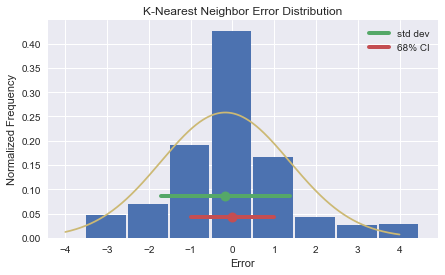

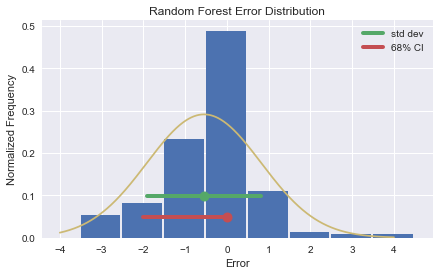

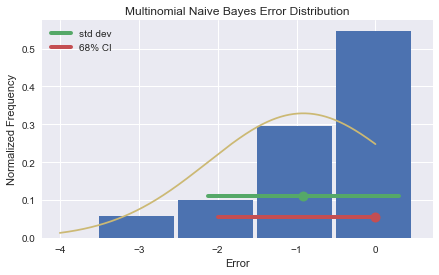

In [47]:
for model, val in LDAResults.iteritems():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

In [48]:
sentimentXtrain = vectorizer.fit_transform(all_text_train)
sentimentXtest = vectorizer.transform(all_text_test)

sentimentYtrain = topic_dist_train_1_2_3_4_5_df['Sentiment']
sentimentYtest = topic_dist_test_1_2_3_4_5_df['Sentiment']

nb_classifier = LogisticRegression().fit(sentimentXtrain, sentimentYtrain)

ySentimentTrain = nb_classifier.predict(sentimentXtrain)
ySentimentTest = nb_classifier.predict(sentimentXtest)

topic_dist_train_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTrain
topic_dist_test_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTest

In [49]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
features.append(topic_dist_train_1_2_3_4_5_df.columns[numTopics+2])
print features

['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Sentiment_Predicted']


In [50]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

FinalResults = {}

In [51]:
clfs = [KNN(),MultinomialNB(),RFClassifier()]
clf_names = ['K-Nearest Neighbor','Multinomial Naive Bayes','Random Forest']

for (i, clf_) in enumerate(clfs):
    clf = clf_.get_model(x_train, y_train)
    preds = clf.get_predictions(x_test)
    
    precision = metrics.precision_score(y_test, preds, average = 'micro')
    recall = metrics.recall_score(y_test, preds, average = 'micro')
    f1 = metrics.f1_score(y_test, preds, average = 'micro')
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    FinalResults[clf_names[i]] = data

In [52]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(FinalResults).T[cols].T

,K-Nearest Neighbor,Multinomial Naive Bayes,Random Forest
precision,0.496818,0.506745,0.537401
recall,0.496818,0.506745,0.537401
f1_score,0.496818,0.506745,0.537401
accuracy,0.496818,0.506745,0.537401


In [53]:
for model, val in FinalResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

-------------------------
MODEL: K-Nearest Neighbor
-------------------------
The precision for this classifier is 0.496817518248
The recall for this classifier is    0.496817518248
The f1 for this classifier is        0.496817518248
The accuracy for this classifier is  0.496817518248
Here is the classification report:
             precision    recall  f1-score   support

          1       0.43      0.53      0.48      1271
          2       0.21      0.16      0.18       897
          3       0.22      0.13      0.16      1600
          4       0.34      0.30      0.32      4679
          5       0.62      0.70      0.66      8678

avg / total       0.47      0.50      0.48     17125

--------------------
MODEL: Random Forest
--------------------
The precision for this classifier is 0.537401459854
The recall for this classifier is    0.537401459854
The f1 for this classifier is        0.537401459854
The accuracy for this classifier is  0.537401459854
Here is the classification report:

In [54]:
# Train Data
data_1stars_train = {"text": all_1stars_text_train, "rating": all_1stars_labels_train}
data_1stars_train = pd.DataFrame(data_1stars_train)

data_2stars_train = {"text": all_2stars_text_train, "rating": all_2stars_labels_train}
data_2stars_train = pd.DataFrame(data_2stars_train)

data_3stars_train = {"text": all_3stars_text_train, "rating": all_3stars_labels_train}
data_3stars_train = pd.DataFrame(data_3stars_train)

data_4stars_train = {"text": all_4stars_text_train, "rating": all_4stars_labels_train}
data_4stars_train = pd.DataFrame(data_4stars_train)

data_5stars_train = {"text": all_5stars_text_train, "rating": all_5stars_labels_train}
data_5stars_train = pd.DataFrame(data_5stars_train)

# Test Data
data_1stars_test = {"text": all_1stars_text_test, "rating": all_1stars_labels_test}
data_1stars_test = pd.DataFrame(data_1stars_test)

data_2stars_test = {"text": all_2stars_text_test, "rating": all_2stars_labels_test}
data_2stars_test = pd.DataFrame(data_2stars_test)

data_3stars_test = {"text": all_3stars_text_test, "rating": all_3stars_labels_test}
data_3stars_test = pd.DataFrame(data_3stars_test)

data_4stars_test = {"text": all_4stars_text_test, "rating": all_4stars_labels_test}
data_4stars_test = pd.DataFrame(data_4stars_test)

data_5stars_test = {"text": all_5stars_text_test, "rating": all_5stars_labels_test}
data_5stars_test = pd.DataFrame(data_5stars_test)

In [55]:
train_pieces = [data_1stars_train, data_2stars_train, data_3stars_train, data_4stars_train, data_5stars_train]
train_data = pd.concat(train_pieces, ignore_index=True)
train_data['predicted_rating'] = pd.Series('training_data', index=train_data.index)
print "Train Data", len(train_data)

test_pieces = [data_1stars_test, data_2stars_test, data_3stars_test, data_4stars_test, data_5stars_test]
test_data = pd.concat(test_pieces, ignore_index=True)
print "Test Data", len(test_data)

Train Data 68492
Test Data 17125


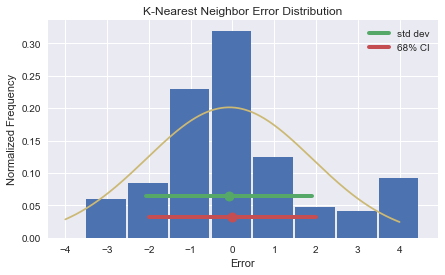

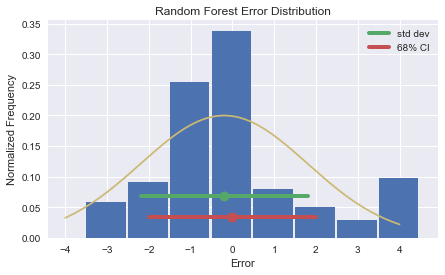

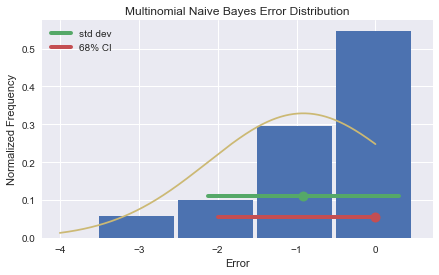

In [56]:
for model, val in FinalResults.iteritems():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    test_data['predicted_rating'] = pd.Series(y_predicted)
    pieces = [train_data, test_data]
    all_data = pd.concat(pieces, ignore_index=True)
    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)